In [1]:
import os
import pandas as pd
import sys
import os
from subprocess import call

#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
import numpy as np

import random
from scipy.stats import ttest_1samp
from sklearn.externals import joblib
from matplotlib.lines import Line2D

random.seed(42)
np.random.seed(42)

from scipy.stats import spearmanr, pearsonr

In [2]:
run_type = 'test' # change to 'validate' and rerun the notebook if interested in the validation set scores

# Data imports & matching a subset of sequences in our validation/test set with precomputed Rosetta scores using sequence names from (Rocklin 2017)

In [3]:
path = "../../../data/"
datasets = ['rd1','rd2', 'rd3', 'rd4']

dfs = {lib:pd.read_table(path+lib+"_stability_scores") for lib in datasets}
all_rds = pd.concat(list(dfs.values())) # except ssm2

all_rds = all_rds.drop_duplicates(subset='name', keep=False) #dropping duplicate records that have the same name. 
# This step is necessary for the correct join

validate = pd.read_pickle(f"{path}for_rosetta_comparison_rocklin_all_rds_{run_type}_sequences_and_truey.pdpkl")

rock_data = [pd.read_csv(f"{path}rd{i}_relax_scored_filtered_betanov15.sc", sep='\t') for i in [1,2,3,4]]

rock_data = pd.concat([rock_data[x][['sequence', 'description', 'total_score', 'exposed_hydrophobics']] for x in [0,1,2,3]]).set_index('sequence')

validate_meta = all_rds.set_index('sequence').loc[validate.rep].reset_index().copy()

validate_meta.loc[:,'predicted_unirep_fusion_stability'] = np.load(f"{path}rocklin_all_rds__all_rds_stability__all_1900__{run_type}__predictions.npy")

validate_meta.loc[:,'target'] =validate.target

ids_in_common = np.intersect1d(rock_data.description.values,validate_meta.name.dropna().values)

rock_data = rock_data.reset_index().set_index('description')

common_df = validate_meta.set_index('name').loc[ids_in_common]

common_df = common_df.join(rock_data, lsuffix='val', rsuffix='ros_file')

/home/gr/miniconda3/envs/grig_alldatasets_run/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [4]:
corr_us = spearmanr(common_df['predicted_unirep_fusion_stability'],common_df['target'])
corr_us[0]

0.59324830254913208

In [5]:
std_us = pd.Series([
    spearmanr(
        common_df.loc[intersec_ids_sample,'predicted_unirep_fusion_stability'],
        common_df.loc[intersec_ids_sample,'target'])[0] for intersec_ids_sample in [
            np.random.choice(
                        common_df.index, size = np.int(common_df.index.shape[0]/2), replace=False
                    ) for i in range(30)
                ] 
]).std()

In [6]:
corr_rosetta_npsa = spearmanr(common_df['exposed_hydrophobics'],common_df['target'])
corr_rosetta_npsa[0]

0.31861509454517545

In [7]:
std_rosetta_npsa  = pd.Series([
    spearmanr(
        common_df.loc[intersec_ids_sample,'exposed_hydrophobics'],
        common_df.loc[intersec_ids_sample,'target'])[0] for intersec_ids_sample in [
            np.random.choice(
                        common_df.index, size = np.int(common_df.index.shape[0]/2), replace=False
                    ) for i in range(30)
                ] 
]).std()

In [8]:
common_df['neg_total_score'] = -common_df['total_score']

In [9]:
corr_rosetta = spearmanr(common_df['neg_total_score'],common_df['target'])
corr_rosetta[0]

0.41687190701920973

In [10]:
std_rosetta = pd.Series([
    spearmanr(
        common_df.loc[intersec_ids_sample,'neg_total_score'],
        common_df.loc[intersec_ids_sample,'target'])[0] for intersec_ids_sample in [
            np.random.choice(
                        common_df.index, size = np.int(common_df.index.shape[0]/2), replace=False) for i in range(30)
                ] 
]).std()

In [11]:
from scipy.stats import ttest_ind_from_stats

ttest_ind_from_stats(mean1=corr_rosetta[0], std1=std_rosetta, nobs1=30,
                     mean2=corr_us[0], std2 = std_us, nobs2=30)

Ttest_indResult(statistic=-34.950289561461574, pvalue=1.1563889925879322e-40)

In [12]:
ttest_ind_from_stats(mean1=corr_rosetta_npsa[0], std1=std_rosetta_npsa, nobs1=30,
                     mean2=corr_us[0], std2 = std_us, nobs2=30)

Ttest_indResult(statistic=-50.412632392190865, pvalue=1.3521295221711189e-49)

In [16]:
sys.path.append("../../")

import common_v2.plot_style_utils
palette = common_v2.plot_style_utils.set_pub_plot_context(colors='categorical', context="poster")

Text(0.5,1,'$\\rho$=0.32')

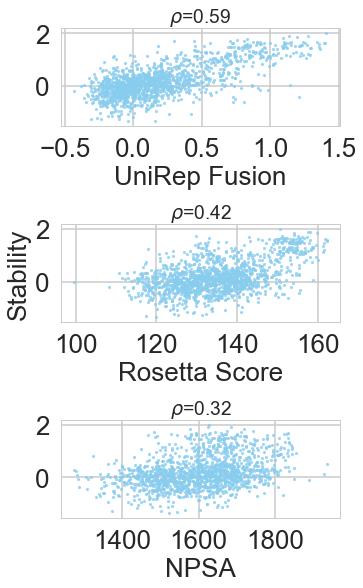

In [17]:
fig, axs = plt.subplots(3,1,sharey=False, gridspec_kw={'hspace':1})
fig.set_figwidth(5)
fig.set_figheight(9)
for ax in axs:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(26)
    
size=10
fit_reg=False

sns.regplot(common_df['predicted_unirep_fusion_stability'],common_df['target'], fit_reg=fit_reg, ax=axs[0], 
            scatter_kws={'s':size}, color=palette[0])
axs[0].set_xlabel("UniRep Fusion")
axs[0].set_ylabel("")
axs[0].set_ylabel("")
axs[0].set_title(f"$\\rho$={np.round(corr_us[0],2)}")


sns.regplot(
    -common_df['total_score'],common_df['target'], ax=axs[1], fit_reg=fit_reg, 
            scatter_kws={'s':size}, color=palette[0])
axs[1].set_xlabel("Rosetta Score")
axs[1].set_ylabel("Stability")
axs[1].set_title(f"$\\rho$={np.round(corr_rosetta[0],2)}")


sns.regplot(
    common_df['exposed_hydrophobics'],common_df['target'], fit_reg=fit_reg, ax=axs[2], 
            scatter_kws={'s':size}, color=palette[0])
axs[2].set_xlabel("NPSA")
axs[2].set_ylabel("")
axs[2].set_title(f"$\\rho$={np.round(corr_rosetta_npsa[0],2)}")
#plot_style_utils_v2.save_for_pub(fig, "../figures/rosetta_scatte", dpi=300)